# Get phenotypes associated with a list of genes from high content screens
This notebook takes a list of gene symbols and queries the IDR
for phenotypes associated with the genes in high content screens.

In [1]:
import csv
import os
import pandas as pd
from tempfile import NamedTemporaryFile

import scipy
import numpy
from skimage import filters
import matplotlib.pyplot as plt
from idr import connection

import requests
import tifffile

### Set up where to query and session

In [2]:
INDEX_PAGE = "https://idr.openmicroscopy.org/webclient/?experimenter=-1"

# create http session
with requests.Session() as session:
    request = requests.Request('GET', INDEX_PAGE)
    prepped = session.prepare_request(request)
    response = session.send(prepped)
    if response.status_code != 200:
        response.raise_for_status()

### Get list of genes to query either from file (one gene symbol per line)
or enter directly in list in notebook.

In [3]:
# uncomment the next two lines if you would rather read gene list
# in from a file
# with open('./includes/FiveExampleGenes.txt') as f:
#    genes = f.read().splitlines()

# comment out the next line if you have read in the gene list from a file
#genes = ['ASH2L', 'ash2', '85441']
genes = ['CDK5RAP2','CETN2']
# check the gene list has been read in
genes[:5]

['CDK5RAP2', 'CETN2']

### Set up base URLS so can use shorter variable names later on

In [4]:
SCREENS_PROJECTS_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/?value={value}"
PLATES_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/plates/?value={value}&id={screen_id}"
DATASETS_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/datasets/?value={value}&id={project_id}"
IMAGES_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/images/?value={value}&node={parent_type}&id={parent_id}"
ATTRIBUTES_URL = "https://idr.openmicroscopy.org/webclient/api/annotations/?type=map&image={image_id}"

### Find images for each gene specified
For each gene, search of images either in plates or datasets then search for phenotypes associated with the images.
The results are saved in a CSV file.

In [5]:
TYPE = "gene"
KEYS = {"phenotype":
    ("Phenotype",
     "Phenotype Term Name",
     "Phenotype Term Accession",
     "Phenotype Term Accession URL")
}

#### Helper method
Parse the output of the json and save it into the CVS file.

In [6]:
def parse_annotation(writer, json_data, name, data_type):
    screen_name = "-"
    plate_name = "-"
    project_name = "-"
    dataset_name = "-"
    if data_type == 'datasets':
        project_name = name
    else:
        screen_name = name
     
    for p in json_data[data_type]:
        parent_id = p['id']
        if data_type == 'datasets':
            dataset_name = p['name']
        else:
            plate_name = p['name']
        qs3 = {'key': TYPE, 'value': gene,
                'parent_type': data_type[:-1], 'parent_id': parent_id}
        url3 = IMAGES_URL.format(**qs3)
        for i in session.get(url3).json()['images']:

            image_id = i['id']
            url4 = ATTRIBUTES_URL.format(**{'image_id': image_id})
            for a in session.get(url4).json()['annotations']:
                ontologies = []  # for ontology terms for a phenotype
                row = {}
                for v in a['values']:
                    if str(v[0]) in KEYS['phenotype']:
                        if str(v[0]) in ['Phenotype']:  # has phenotype
                            row[str(v[0])] = v[1]  # so create row

                        # if there are ontology mappings for the
                        # phenotype, add them to the ontologies list
                        ontList = ['Phenotype Term Name',
                                   'Phenotype Term Accession',
                                   'Phenotype Term Accession URL']

                        if str(v[0]) in ontList:
                            ontologies.extend([str(v[0]), str(v[1])])
                    if row:
                        if (len(ontologies) > 0):  # 1+ ontology mapping
                            row.update({'Gene': gene,
                                        'Screen': screen_name,
                                        'Plate': plate_name,
                                        'Image': image_id,
                                        'Project' : project_name,
                                        'Dataset': dataset_name})
                            # we have the start of a row now
                            # but we want to print out as many rows
                            # as there are ontology mappings
                            # so if there is mapping to 1 ontology term
                            # print 1 row, if there are 2 ontology terms
                            # print 2 rows etc
                            numberOfRows = len(ontologies)/6
                            # this is 3 pairs of ontology values per
                            # mapping, add the ontology mappings and print
                            n = 1
                            while (n <= numberOfRows):
                                row.update({ontologies[0]: ontologies[1],
                                            ontologies[2]: ontologies[3],
                                            ontologies[4]: ontologies[5]})
                                # remove that set of ontology mappings
                                ontologies = ontologies[6:]
                                writer.writerow(row)
                                n = n + 1

#### Retrieve data 
A CSV file is first created in the ``home`` directory. The CSV file can then be downloaded to your local machine. To download it, click ``File > Open``, select the CSV file and open it, then click ``File > Download``.

In [7]:
home = os.path.expanduser("~")
csvfile = NamedTemporaryFile("w", delete=False, newline='', dir=home, suffix=".csv")
try:
    fieldnames = [
        'Gene', 'Screen', 'Plate', 'Project', 'Dataset', 'Image',
        'Phenotype', 'Phenotype Term Name', 'Phenotype Term Accession',
        'Phenotype Term Accession URL']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for gene in genes:
        qs1 = {'key': TYPE, 'value': gene}
        url1 = SCREENS_PROJECTS_URL.format(**qs1)
        json = session.get(url1).json()
        for s in json['screens']:
            qs2 = {'key': TYPE, 'value': gene, 'screen_id': s['id']}
            url2 = PLATES_URL.format(**qs2)
            parse_annotation(writer, session.get(url2).json(), s['name'], 'plates')
        for p in json['projects']:
            qs2 = {'key': TYPE, 'value': gene, 'project_id': p['id']}
            url2 = DATASETS_URL.format(**qs2)
            parse_annotation(writer, session.get(url2).json(), p['name'], 'datasets')           
finally:
    csvfile.close()

### Load output into a data frame
View a subset of the data.

In [8]:
df = pd.read_csv(csvfile.name)
df.head(60)

,Gene,Screen,Plate,Project,Dataset,Image,Phenotype,Phenotype Term Name,Phenotype Term Accession,Phenotype Term Accession URL
0,CDK5RAP2,idr0013-neumann-mitocheck/screenA (6),LT0065_04,-,-,1554140,polylobed (automatic),polylobed nuclear phenotype,CMPO_0000357,http://www.ebi.ac.uk/cmpo/CMPO_0000357
1,CDK5RAP2,idr0013-neumann-mitocheck/screenA (6),LT0065_04,-,-,1554140,dynamic changes (automatic),increased variability of nuclear shape in popu...,CMPO_0000345,http://www.ebi.ac.uk/cmpo/CMPO_0000345
2,CDK5RAP2,idr0013-neumann-mitocheck/screenA (6),LT0065_05,-,-,1554429,polylobed (automatic),polylobed nuclear phenotype,CMPO_0000357,http://www.ebi.ac.uk/cmpo/CMPO_0000357
3,CDK5RAP2,idr0013-neumann-mitocheck/screenA (6),LT0065_05,-,-,1554429,dynamic changes (automatic),increased variability of nuclear shape in popu...,CMPO_0000345,http://www.ebi.ac.uk/cmpo/CMPO_0000345
4,CDK5RAP2,idr0013-neumann-mitocheck/screenA (6),LT0065_06,-,-,1554686,polylobed (automatic),polylobed nuclear phenotype,CMPO_0000357,http://www.ebi.ac.uk/cmpo/CMPO_0000357
5,CDK5RAP2,idr0013-neumann-mitocheck/screenA (6),LT0065_06,-,-,1554686,dynamic changes (automatic),increased variability of nuclear shape in popu...,CMPO_0000345,http://www.ebi.ac.uk/cmpo/CMPO_0000345
6,CDK5RAP2,-,-,idr0021-lawo-pericentriolarmaterial/experiment...,CDK5RAP2-C,1884816,protein localized to centrosome,protein localized in centrosome phenotype,CMPO_0000425,http://www.ebi.ac.uk/cmpo/CMPO_0000425
7,CDK5RAP2,-,-,idr0021-lawo-pericentriolarmaterial/experiment...,CDK5RAP2-C,1884821,protein localized to centrosome,protein localized in centrosome phenotype,CMPO_0000425,http://www.ebi.ac.uk/cmpo/CMPO_0000425
8,CDK5RAP2,-,-,idr0021-lawo-pericentriolarmaterial/experiment...,CDK5RAP2-C,1884837,protein localized to centrosome,protein localized in centrosome phenotype,CMPO_0000425,http://www.ebi.ac.uk/cmpo/CMPO_0000425
9,CDK5RAP2,-,-,idr0021-lawo-pericentriolarmaterial/experiment...,CDK5RAP2-C,1884813,protein localized to centrosome,protein localized in centrosome phenotype,CMPO_0000425,http://www.ebi.ac.uk/cmpo/CMPO_0000425


#### Filter by a specified phenotype 

In [9]:
value = 'CMPO_0000357'
df_filtered = df[df['Phenotype Term Accession'] == value]
df_filtered.head()

,Gene,Screen,Plate,Project,Dataset,Image,Phenotype,Phenotype Term Name,Phenotype Term Accession,Phenotype Term Accession URL
0,CDK5RAP2,idr0013-neumann-mitocheck/screenA (6),LT0065_04,-,-,1554140,polylobed (automatic),polylobed nuclear phenotype,CMPO_0000357,http://www.ebi.ac.uk/cmpo/CMPO_0000357
2,CDK5RAP2,idr0013-neumann-mitocheck/screenA (6),LT0065_05,-,-,1554429,polylobed (automatic),polylobed nuclear phenotype,CMPO_0000357,http://www.ebi.ac.uk/cmpo/CMPO_0000357
4,CDK5RAP2,idr0013-neumann-mitocheck/screenA (6),LT0065_06,-,-,1554686,polylobed (automatic),polylobed nuclear phenotype,CMPO_0000357,http://www.ebi.ac.uk/cmpo/CMPO_0000357


### Select the image
Select the first image if any

In [10]:
image_id = -1
if ~df_filtered.empty:
    image_id = df_filtered.head(1)['Image'].values[0]
else:
    image_id = df.head(1)['Image'].values[0]
print(image_id)

1554140


## Connect to IDR 

In [11]:
conn = connection('idr.openmicroscopy.org')

Connected to IDR ...


### Load the image 

In [12]:
image = conn.getObject("Image", image_id)
print(image.getName(), image.getDescription())

LT0065_04 [Well F24, Field 1] 


Load the first plane, pre-process it and segment it.

In [13]:
pixels = image.getPrimaryPixels()
image_plane = pixels.getPlane(0, 0, 0)

Text(0.5, 1.0, 'median filtered image')

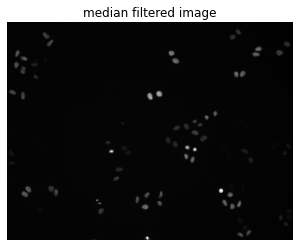

In [14]:
filtered = scipy.ndimage.median_filter(image_plane, size=3)
plt.imshow(filtered, cmap='gray')
plt.axis('off')
plt.title('median filtered image')

Threshold value is 53


Text(0.5, 1.0, 'otsu predicted binary image')

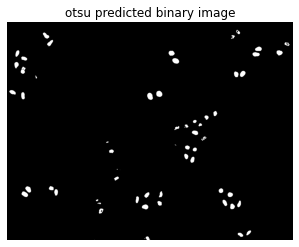

In [15]:
threshold = filters.threshold_otsu(filtered)
print('Threshold value is {}'.format(threshold))
predicted = numpy.uint8(filtered > threshold) * 255
plt.imshow(predicted, cmap='gray')
plt.axis('off')
plt.title('otsu predicted binary image')

### Save the predicted Image 
Save the predicted image as TIFF in the ``home`` directory, the ID of the image as the name of the TIFF file.
To download it, click ``File > Open``, select the file and open it (ignore the errror in the text editor), then click ``File > Download``.

In [16]:
name="%s/%s.tif" % (home, image_id)
tifffile.imsave(name, predicted)

## Close the connection 

In [17]:
conn.close()

### Exercises

To run the exercises below, you will need to be connected to IDR. If you have run the cell in the notebook closing the connection to IDR i.e. ``conn.close()``, you will first need to 
 * re-run the cell connection to IDR or alternatively OR
 * add a new cell using ``Insert > Cell below`` and add ``conn = connection('idr.openmicroscopy.org')`` and run the cell.

For each exercise, create a new cell by clicking on ``Insert > Cell below``, write the code then run the cell.

Exercise 1:
Iterate through the ``df_filtered`` data frame to threshold each image and save it as a TIFF file.

See [Solution](solutions/GenesToPhenotypesSolutions.ipynb)

Copyright (C) 2017-2021 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.